[Probability and Statistics for Data Science](https://www.ps4ds.net/) 

Code for Section 12.8.1

Temperature estimation given the day of the year and the hour of the day using neural networks. This is a toy problem (although it uses real temperature data from Manhattan, Kansas), which requires nonlinear estimation\
Topics: Regression, neural networks, deep learning, overfitting, early stopping

Author: Carlos Fernandez-Granda\
Data source: https://www1.ncdc.noaa.gov/pub/data/uscrn/products/

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from os import listdir
from scipy import stats
import datetime as dt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import copy

font_size = 15
font_size_ticks = 15

np.set_printoptions(precision=3)

# Check if MPS is available, if it is, it will be used for the large model
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())
device = torch.device("mps")

MPS available: True
MPS built: True


In [16]:
file_name_temperature_2015 = "../data/weather/temperatures_2015.npy"
file_name_temperature_2016 = "../data/weather/temperatures_2016.npy"
file_name_times_2015 = "../data/weather/times_2015.npy"
file_name_times_2016 = "../data/weather/times_2016.npy"
file_name_dates_2015 = "../data/weather/dates_2015.npy"
file_name_dates_2016 = "../data/weather/dates_2016.npy"

data_matrix_2015 = np.load(file_name_temperature_2015)
data_matrix_2016 = np.load(file_name_temperature_2016)
time_matrix_2015 = np.load(file_name_times_2015)
time_matrix_2016 = np.load(file_name_times_2016)
date_matrix_2015 = np.load(file_name_dates_2015)
date_matrix_2016 = np.load(file_name_dates_2016)

file_name_list = np.load('../data/weather/weather_station_names.npy')

def process_name(x):
    x = x[14:]
    x = x[:-7]
    x = x.translate(str.maketrans('','','_1234567890'))
    return x[2:] + ", " + x[:2]

In [17]:
station = 52
name = process_name(file_name_list[station]) 
print(name)

Manhattan, KS


In [18]:
def remove_faulty_measurements(data,verbose):
    min_val = -100 # We assume temperatures cannot be lower than -100
    for ind in range(len(data)):
        median = np.median(data[data > min_val])
        if data[ind] < min_val:
            if verbose:
                print(str(ind) + ": " + str(data[ind]))
            aux_ind = ind-1
            while aux_ind > 0:
                if data[aux_ind] > min_val:
                    data[ind] = data[aux_ind]
                    if verbose:
                        print("Entry " + str(aux_ind) + " changed to " + str(data[ind]))
                    break
                else:
                    ind -= 1
    return data

verbose = False
temperature_2015 = remove_faulty_measurements(data_matrix_2015[:,station],verbose)
n_2015 = len(temperature_2015)
temperature_2016 = remove_faulty_measurements(data_matrix_2016[:,station],verbose)
n_2016 = len(temperature_2016)

In [19]:
hour_2015 = (time_matrix_2015[:,station]/100).astype(int)
hour_2016 = (time_matrix_2016[:,station]/100).astype(int)

day_2015 = np.array([dt.datetime.strptime(str(int(date)), '%Y%m%d').timetuple().tm_yday for date in date_matrix_2015[:,station]])
day_2016 = np.array([dt.datetime.strptime(str(int(date)), '%Y%m%d').timetuple().tm_yday for date in date_matrix_2016[:,station]])

n_data_366 = np.sum(day_2016==366)
temperature_2016 = temperature_2016[:-n_data_366]
day_2016 = day_2016[:-n_data_366]
hour_2016 = hour_2016[:-n_data_366]

In [74]:
# Arrays for visualization of training and test data
n_days = 365
n_hours = 24

temperature_grid_2015 = np.zeros((n_hours,n_days))
temperature_grid_2016 = np.zeros((n_hours,n_days))
for h in np.arange(0,n_hours,1):
    for m in np.arange(1,n_days+1,1):
        temperature_grid_2015[h,m-1] = np.mean(temperature_2015[(hour_2015 == h) & (day_2015 == m)])
        temperature_grid_2016[h,m-1] = np.mean(temperature_2016[(hour_2016 == h) & (day_2016 == m)])
max_mean_temp_2015 = np.max(temperature_grid_2015)
max_mean_temp_2016 = np.max(temperature_grid_2016)
max_mean_temp = np.max(np.array([max_mean_temp_2015,max_mean_temp_2016]))
min_mean_temp_2015 = np.min(temperature_grid_2015)
min_mean_temp_2016 = np.min(temperature_grid_2016)
min_mean_temp = np.min(np.array([min_mean_temp_2015,min_mean_temp_2016]))

In [20]:
n_train = len(temperature_2015)
n_test = len(temperature_2016)

X_train = np.array([hour_2015.astype(float),day_2015.astype(float)]).T
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(temperature_2015, dtype=torch.float32).reshape(-1, 1)
X_test = np.array([hour_2016.astype(float),day_2016.astype(float)]).T
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(temperature_2016, dtype=torch.float32).reshape(-1, 1)

n_batch = 100
# set up the data loaders for training set and test set
training_loader = DataLoader(list(zip(X_train_tensor, y_train_tensor)), shuffle=True, batch_size=n_batch)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), shuffle=False, batch_size=n_test)

In [21]:
# Small neural network with two layers
torch.manual_seed(2023)
n_hidden = 2
small_model = nn.Sequential(
    nn.Linear(2, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, 1)
)

In [22]:
# Train the model
n_epochs = 2000
optimizer = optim.Adam(small_model.parameters(), lr=1e-3)
small_model.train()
training_error_small_model = []
test_error_small_model = []
MSEloss = nn.MSELoss()
verbose = False
for epoch in range(n_epochs):
    if verbose:
        for name, param in small_model.named_parameters():
            if param.requires_grad:
                print(name, param.data)
    training_aux = 0
    for X_batch, y_batch in training_loader:
        X_batch = X_batch.to(torch.float32)
        y_batch = y_batch.to(torch.float32)
        y_pred = small_model(X_batch)
        if verbose:
            print(X_batch[:3,:])
            print(y_pred[:3])
        training_loss = MSEloss(y_pred, y_batch)
        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()
        training_aux += np.sum( (y_pred.detach().numpy()-y_batch.detach().numpy())**2 )
    training_error_small_model.append(training_aux / n_train)
    for X_batch_test, y_batch_test in test_loader:
        X_batch_test = X_batch_test.to(torch.float32)
        y_batch_test = y_batch_test.to(torch.float32)
        y_pred_test = small_model(X_batch_test)
        test_error = np.sum( (y_pred_test.detach().numpy()-y_batch_test.detach().numpy())**2 ) / n_test
        test_error_small_model.append(test_error)

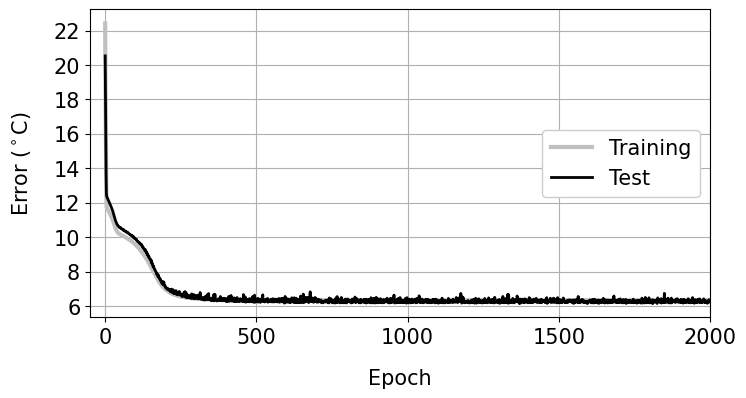

In [23]:
epoch_ticks = np.arange(0,2500,500)
plt.figure(figsize=(8,4))
plt.xticks(epoch_ticks,fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlim([-50,len(training_error_small_model)])
plt.ylabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad = 15)
plt.xlabel(r'Epoch',fontsize=font_size,labelpad = 15)
plt.plot(np.sqrt(training_error_small_model),color="silver",lw=3,
         label="Training")
plt.plot(np.sqrt(test_error_small_model),color="black",lw=2,
         label="Test")
plt.grid()
plt.legend(fontsize=font_size,loc="center right",framealpha=1);

In [24]:
print("Training error",round(float(np.sqrt(training_error_small_model[-1])),3))
print("Test error",round(float(np.sqrt(test_error_small_model[-1])),3))

Training error 6.316
Test error 6.252


In [25]:
print("Learned parameters")
for name, param in small_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

Learned parameters
0.weight tensor([[ 0.0486, -0.0369],
        [-0.0057, -0.0487]])
0.bias tensor([13.0397, 10.0781])
2.weight tensor([[ 4.7568, -6.9905]])
2.bias tensor([0.2188])


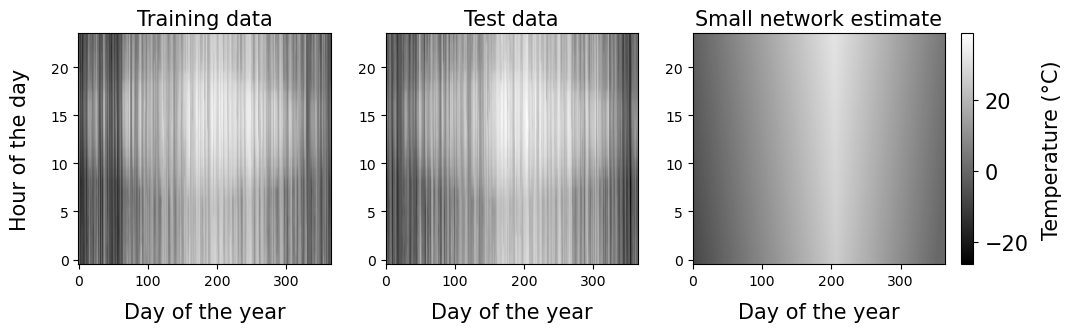

In [106]:
day_ticks = np.arange(0,400,100)
n_hours = 24
n_days = 365
estimate_grid = np.zeros((n_hours,n_days))
for ind_day in range(n_days):
    for ind_hour in range(n_hours):
        hour = float(ind_hour)
        day = float(1 + ind_day)
        features = torch.tensor([[hour, day]]).to(torch.float32)
        estimate_grid[ind_hour,ind_day] = small_model(features).detach().numpy().item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3),width_ratios=[3,3,3.75])

ax1.imshow(temperature_grid_2015, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                origin='lower', aspect='auto')
ax1.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax1.set_ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
ax1.set_title("Training data",fontsize=font_size);

ax2.imshow(temperature_grid_2016, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                origin='lower', aspect='auto')
ax2.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax2.set_title("Test data",fontsize=font_size);

im = ax3.imshow(estimate_grid, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    origin='lower', aspect='auto')
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=font_size_ticks,pad = 5)
cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 10)
ax3.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax3.set_title("Small network estimate",fontsize=font_size);

In [67]:
# Large neural network with 4 layers and 100 neurons in the two intermediate hidden layers
torch.manual_seed(2024)
n_hidden = 100
large_model = nn.Sequential(
    nn.Linear(2, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, 1)
)
if torch.backends.mps.is_available():
    large_model = large_model.to(device)

In [68]:
# Train the model, this will take a while
n_epochs = 5000 
optimizer = optim.Adam(large_model.parameters(), lr=5e-5)# 5e-5
large_model.train()
training_error_large_model = []
test_error_large_model = []
MSEloss = nn.MSELoss()
verbose = True
early_model_epoch = 300 
for epoch in range(n_epochs):
    training_aux = 0
    if verbose and np.mod(epoch,500)==0:
        print("Epoch ",epoch)
    for X_batch, y_batch in training_loader:
        if torch.backends.mps.is_available():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
        else:
            X_batch = X_batch.to(torch.float32)
            y_batch = y_batch.to(torch.float32)
        y_pred = large_model(X_batch)
        training_loss = MSEloss(y_pred, y_batch)
        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()
        training_aux += torch.sum( (y_pred.detach()-y_batch.detach())**2 )
    training_error_large_model.append((training_aux/ n_train).item())
    for X_batch_test, y_batch_test in test_loader:
        X_batch_test = X_batch_test.to(device)
        y_batch_test = y_batch_test.to(device)
        y_pred_test = large_model(X_batch_test)
        test_error = torch.sum( (y_pred_test.detach()-y_batch_test.detach())**2 ) / n_test
        test_error_large_model.append(test_error.item())
    if epoch == early_model_epoch:
        early_model_large = copy.deepcopy(large_model)

Epoch  1
Epoch  501
Epoch  1001
Epoch  1501
Epoch  2001
Epoch  2501
Epoch  3001
Epoch  3501
Epoch  4001
Epoch  4501


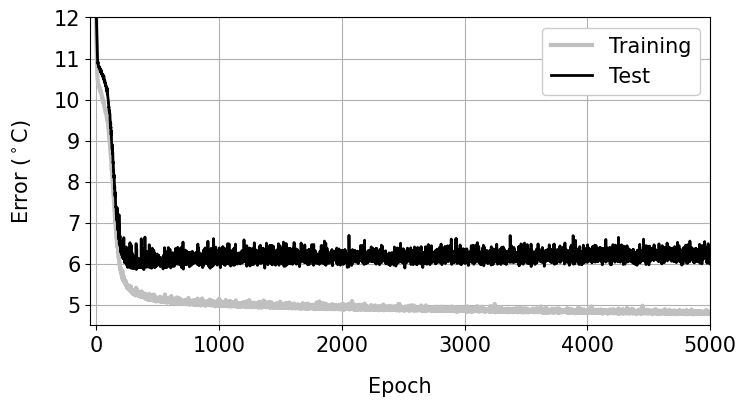

In [70]:
msize = 5
medgewidth = 1
plt.figure(figsize=(8,4))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.ylim([4.5,12])
plt.xlim([-50,len(training_error_large_model)])
plt.ylabel(r'Error ($^\circ$C)',fontsize=font_size_ticks,labelpad = 15)
plt.xlabel(r'Epoch',fontsize=font_size_ticks,labelpad = 15)
plt.plot(np.sqrt(np.array(training_error_large_model)),color="silver",lw=3,
         label="Training")
plt.plot(np.sqrt(test_error_large_model),color="black",lw=2,
         label="Test")
plt.grid()
plt.legend(fontsize=font_size_ticks,loc="upper right",framealpha=1);

In [71]:
print("Large model")
print("\nEpoch " + str(early_model_epoch))
print("Training error",round(np.sqrt(training_error_large_model[early_model_epoch]),3))
print("Test error",round(np.sqrt(test_error_large_model[early_model_epoch]),3))
print("\nEpoch " + str(n_epochs))
print("Training error",round(np.sqrt(training_error_large_model[-1]),3))
print("Test error",round(np.sqrt(test_error_large_model[-1]),3))

Large model

Epoch 300
Training error 5.281
Test error 6.066

Epoch 5000
Training error 4.795
Test error 6.357


In [72]:
estimate_grid_early = np.zeros((n_hours,n_days))
for ind_day in range(n_days):
    for ind_hour in range(n_hours):
        hour = float(ind_hour)
        day = float(1 + ind_day)
        if torch.backends.mps.is_available():
            features = torch.tensor([[hour, day]]).to(device)
            estimate_grid_early[ind_hour,ind_day] = early_model_large(features).detach().cpu().numpy().item()
        else:
            features = torch.tensor([[hour, day]]).to(torch.float32)
            estimate_grid_early[ind_hour,ind_day] = early_model_large(features).detach().numpy().item()
estimate_grid_last = np.zeros((n_hours,n_days))
for ind_day in range(n_days):
    for ind_hour in range(n_hours):
        hour = float(ind_hour)
        day = float(1 + ind_day)
        if torch.backends.mps.is_available():
            features = torch.tensor([[hour, day]]).to(device)
            estimate_grid_last[ind_hour,ind_day] = large_model(features).detach().cpu().numpy().item()
        else:
            features = torch.tensor([[hour, day]]).to(torch.float32)
            estimate_grid_last[ind_hour,ind_day] = large_model(features).detach().numpy().item()
            
min_temp = np.min(estimate_grid_last)
max_temp = np.max(estimate_grid_last)

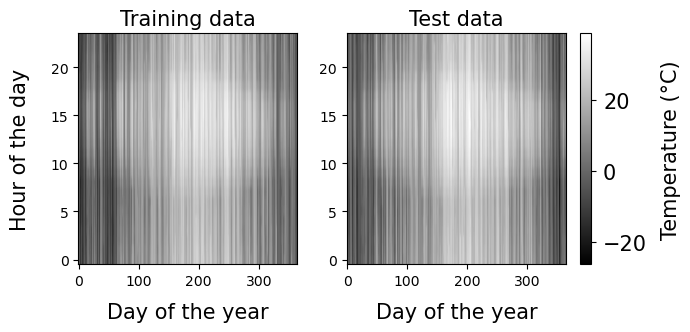

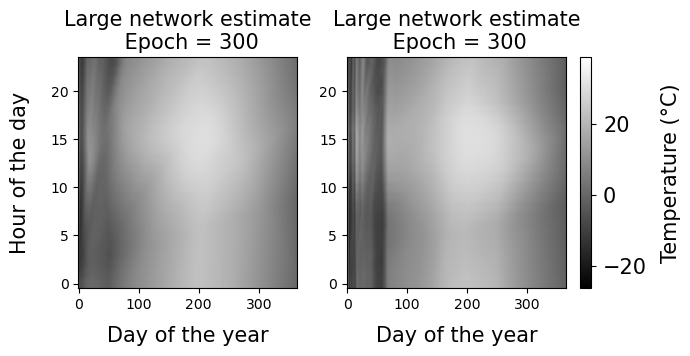

In [105]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,3),width_ratios=[4,5])

ax1.imshow(temperature_grid_2015, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                origin='lower', aspect='auto')
ax1.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax1.set_ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
ax1.set_title("Training data",fontsize=font_size);

im = ax2.imshow(temperature_grid_2016, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                origin='lower', aspect='auto')
ax2.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax2.set_title("Test data",fontsize=font_size);
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=font_size_ticks,pad = 5)
cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 10)


fig, (ax3,ax4) = plt.subplots(1, 2, figsize=(7,3),width_ratios=[4,5])
ax3.imshow(estimate_grid_early, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    origin='lower', aspect='auto')
ax3.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax3.set_ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
ax3.set_title("Large network estimate\n Epoch = " + str(300),fontsize=font_size);

im2 = ax4.imshow(estimate_grid_last, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    origin='lower', aspect='auto')
cbar = plt.colorbar(im2)
cbar.ax.tick_params(labelsize=font_size_ticks,pad = 5)
cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 10)
ax4.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax4.set_title("Large network estimate\n Epoch = " + str(300),fontsize=font_size);